## Experiments


### General Imports and Functions 

In [1]:
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from policyiter import evaluation, improvement, treebuilder, config
from tqdm import tqdm

In [2]:
def create_random_policy(pre_decision_states, post_decision_states):
    """
    Method to create a random Policy
    :param pre_decision_states: Pre-Decision states represented by an array
    :param post_decision_states: Post-Decision states represented by an array
    :return: policy represented by an array (indecis: Pre-Decision states, values: Post-Decision states)
    """
    # Number of pre decision states to iterate over
    n_pre_states = len(pre_decision_states)

    # initialize policy
    policy = [None] * n_pre_states

    counter = 0

    for pre_state in range(0, n_pre_states):

        # Last States have an empty trans_mat because the time horizon is reached and no decision can be made
        if (pre_decision_states[pre_state]["trans_mat"] is not None):
            random.seed(config.SEED)
            random_state = random.choice(pre_decision_states[pre_state]["trans_mat"].columns.levels[0])
            price_index = pre_decision_states[pre_state]["trans_mat"].index[0]

            policy[pre_state] = pre_decision_states[pre_state]["trans_mat"].loc[price_index][random_state]\
            .iloc[0][0]["post_state"]

    return policy



### State Space Evolution

In [3]:
def build_tree(PRICE_MIN, PRICE_MAX, PRICE_STEP_SIZE, ENERGY_MIN, ENERGY_MAX, ENERGY_STEP_SIZE, EFF_COEFF, 
               MAX_PULL, MAX_PUSH, MAX_TIME, INITIAL_STATE):

    # Definition of possible Price levels
    price_levels = np.arange(PRICE_MIN, PRICE_MAX + PRICE_STEP_SIZE, PRICE_STEP_SIZE)

    # Definition of possible Energy levels
    energy_levels = np.arange(ENERGY_MIN, ENERGY_MAX + ENERGY_STEP_SIZE, ENERGY_STEP_SIZE)

    time_horizon = np.arange(1, MAX_TIME + 1)

    pre_decision_states = []
    post_decision_states = []

    pre_decision_states.append({"v": None, "state": INITIAL_STATE, "trans_mat": None})

    # Create the tree
    start_time_tree = time.process_time()
    pre_decision_states, post_decision_states = treebuilder.create_tree(time_horizon,
                                                                        energy_levels,
                                                                        price_levels,
                                                                        pre_decision_states,
                                                                        post_decision_states,
                                                                        MAX_PULL,
                                                                        MAX_PUSH, 0)
    stop_time_tree = time.process_time()

    time_tree = stop_time_tree - start_time_tree

    # returns 1. #pre_decision_states, 2. #post_decision_states, 3. #price_levels, 4. #energy_levels, 
    # 5. Time time_tree
    return(len(pre_decision_states), len(post_decision_states), len(price_levels), len(energy_levels), time_tree)




### Plot State Space growth

#### Initial Parameters

In [19]:
# DEFINITION OF PRICE LEVELS (DISCRETIZATION CAN BE MODIFIED WITH THE STEP SIZE)
PRICE_MIN = 1
PRICE_MAX = 2
PRICE_STEP_SIZE = 1

# DEFINITION OF ENERGY LEVELS (DISCRETIZATION CAN BE MODIFIED WITH THE STEP SIZE)
ENERGY_MIN = 0
ENERGY_MAX = 4
ENERGY_STEP_SIZE = 1

# MAXIMUM TIME STEPS (MUST BE A NATURAL NUMBER GREATER THEN 0)
MAX_TIME = 2

# Initialize state
# Definition of states: [Price, Energy-Level]
INITIAL_STATE = [1, 0]

# Set a seed for the random policy creation
SEED = 42

# EFFICENCY COEFFICIENT MUST BE BETWEEN 0 AND 1
EFF_COEFF = 0.9

MAX_PULL = 100

MAX_PUSH = 100


#### Regarding Energy Levels

In [22]:
experiment_range = range(1,40,1)
experiment_time = []
amount_pre_states = []

for i in tqdm(experiment_range):
    ENERGY_MIN = 0
    ENERGY_MAX = i
    
    pre_states, post_states, _, _, time_tree = build_tree(PRICE_MIN, PRICE_MAX, 
                                                          PRICE_STEP_SIZE, ENERGY_MIN, 
                                                          ENERGY_MAX, ENERGY_STEP_SIZE, EFF_COEFF, 
                                                          MAX_PULL, MAX_PUSH, MAX_TIME, 
                                                          INITIAL_STATE)
    
    amount_pre_states.append(pre_states)
    experiment_time.append(time_tree)

100%|██████████| 39/39 [02:43<00:00, 10.12s/it]


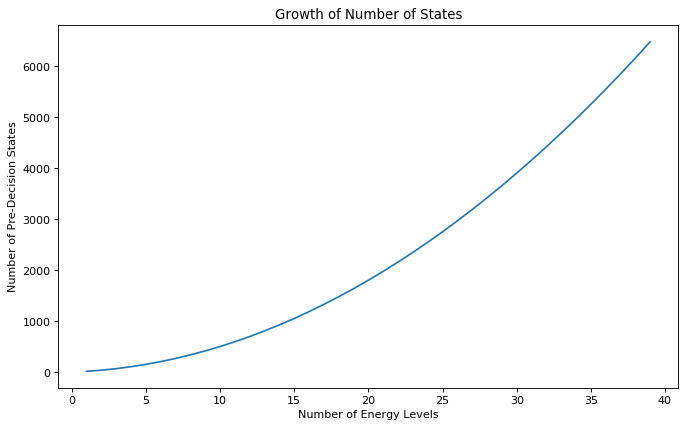

In [21]:
file_name = "preStatesEnergyLevels_"+ str(MAX_TIME) +"_timeSteps_" + str(max(experiment_range)) + "_eLevels_" + str(MAX_PULL) + "_maxPull_" + str(MAX_PUSH) + "_maxPush" 
plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(experiment_range, amount_pre_states)
plt.xlabel("Number of Energy Levels")
plt.ylabel("Number of Pre-Decision States")
plt.title("Growth of Number of States")
plt.savefig('results/'+ file_name +'.png')

In [ ]:
file_name = "timeTreeBuilding_"+ str(MAX_TIME) +"_timeSteps_" + str(max(experiment_range)) + "_eLevels_" + str(MAX_PULL) + "_maxPull_" + str(MAX_PUSH) + "_maxPush" 
plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(experiment_range, amount_pre_states)
plt.xlabel("Number of Energy Levels")
plt.ylabel("Time necessary for Tree building")
plt.title("Growth of Number of States")
plt.savefig('results/'+ file_name +'.png')

### Find marnginal Energy Storage size